# HAIM experiment for Edema Pathology Prediction
## Comparison of original method from MEDomics Udes HAIM repository and use of PyCaret

For additional information on PyCaret classification module : 
- Github complete tutorial : https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Binary%20Classification.ipynb
- PyCaret documentation : https://pycaret.readthedocs.io/en/stable/api/classification.html

For additional information on the HAIM study :
- Paper : https://www.nature.com/articles/s41746-022-00689-4
- Results: https://www.nature.com/articles/s41746-022-00689-4/figures/2

Original results for Edema prediction :
- Original HAIM study : AUC = 0.917
- MEDomics-UdeS HAIM repository : AUC = 0.9147 +/- 0.0072

### Imports

In [1]:
import numpy as np
from pandas import read_csv
from pycaret.classification import ClassificationExperiment
from sklearn.model_selection import StratifiedGroupKFold

### Define constants

In [2]:
FILE_DF = '../data/cxr_ic_fusion_1103.csv'
N_DATA = 45050
PREDICTIVE_COLUMNS_PREFIX = ['de_', 'vd_', 'vp_', 'vmd_', 'vmp_', 'ts_ce_', 'ts_le_', 'ts_pe_', 'n_ecg_', 'n_ech_']
EXPERIMENT = 'Edema'

### Read data from local source

In [3]:
df = read_csv(FILE_DF, nrows=N_DATA)

### Modify the dataset for the HAIM experiment

In [4]:
# Get data where there is a value for Experiment
df = df[df[EXPERIMENT].isin([0, 1])]

# Keep columns for the prediction
columns = ['haim_id', EXPERIMENT]
for column_suffix in PREDICTIVE_COLUMNS_PREFIX:
    for df_column in df.columns:
        if df_column.startswith(column_suffix):
            columns.append(df_column)
df = df[columns]

### Setup

Here we make sure that a haim_id (which isn't unique) appears in only one dataset, and we also proceed to stratified splits.

In [5]:
exp = ClassificationExperiment()
exp.setup(df, target=EXPERIMENT, train_size=0.8, fold_strategy=StratifiedGroupKFold(), fold_groups='haim_id', fold=5)

,Description,Value
0,Session id,5005
1,Target,Edema
2,Target type,Binary
3,Original data shape,"(17182, 4079)"
4,Transformed data shape,"(17182, 4079)"
5,Transformed train set shape,"(13745, 4079)"
6,Transformed test set shape,"(3437, 4079)"
7,Numeric features,4078
8,Preprocess,True
9,Imputation type,simple


### Compare models

Compare all available models sorting by AUC score.

In [6]:
pycaret_model = exp.compare_models(include= ['lr', 'knn', 'nb', 'dt', 'svm',
                                             'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 
                                             'et', 'lightgbm', 'xgboost'], sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8263,0.9061,0.9102,0.8280,0.8671,0.6181,0.6239,1.8860
rf,Random Forest Classifier,0.8287,0.9022,0.9036,0.8348,0.8679,0.6253,0.6294,2.8500
xgboost,Extreme Gradient Boosting,0.8252,0.8989,0.8873,0.8409,0.8634,0.6213,0.6231,74.8920
lightgbm,Light Gradient Boosting Machine,0.8248,0.8932,0.8877,0.8400,0.8632,0.6201,0.6220,12.6020
gbc,Gradient Boosting Classifier,0.7870,0.8584,0.8692,0.8045,0.8356,0.5345,0.5377,152.5840
ada,Ada Boost Classifier,0.7570,0.8212,0.8275,0.7918,0.8092,0.4751,0.4761,30.2500
lda,Linear Discriminant Analysis,0.7240,0.7625,0.7627,0.7875,0.7749,0.4184,0.4189,20.0300
dt,Decision Tree Classifier,0.7537,0.7396,0.7972,0.8054,0.8012,0.4776,0.4777,16.2660
qda,Quadratic Discriminant Analysis,0.7106,0.6167,0.9991,0.6830,0.8113,0.2748,0.3972,40.2520
mlp,MLP Classifier,0.6066,0.5937,0.6587,0.7009,0.6688,0.1751,0.1826,14.4780


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### Create model
#### HAIM model
Make experiment on the same model as the study, XGBoost.

In [7]:
haim_model = exp.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8273,0.9050,0.8908,0.8411,0.8652,0.6253,0.6273
1,0.8315,0.9021,0.8977,0.8421,0.8690,0.6336,0.6361
2,0.8319,0.9079,0.8984,0.8424,0.8695,0.6342,0.6368
3,0.8127,0.8845,0.8738,0.8334,0.8532,0.5949,0.5962
4,0.8228,0.8949,0.8756,0.8455,0.8603,0.6185,0.6192
Mean,0.8252,0.8989,0.8873,0.8409,0.8634,0.6213,0.6231
Std,0.0071,0.0084,0.0106,0.0040,0.0061,0.0144,0.0149


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

#### PyCaret best model
Make experiment on the best model found by PyCaret best_model() function.

In [8]:
pycaret_model = exp.create_model(pycaret_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8193,0.9056,0.9065,0.8216,0.8620,0.6021,0.6082
1,0.8337,0.9078,0.9205,0.8307,0.8733,0.6332,0.6403
2,0.8370,0.9167,0.9218,0.8341,0.8758,0.6407,0.6475
3,0.8145,0.8918,0.8995,0.8200,0.8579,0.5923,0.5976
4,0.8272,0.9085,0.9025,0.8338,0.8668,0.6221,0.6261
Mean,0.8263,0.9061,0.9102,0.8280,0.8671,0.6181,0.6239
Std,0.0085,0.0081,0.0092,0.0060,0.0067,0.0183,0.0188


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tune Model
#### HAIM model
Tune model with the same grid search as the HAIM study, and optimize AUC as used in the study.
HAIM AUC is 0.83 (but it is not sure that they respect the fact a patient can't be in two different sets).

In [9]:
tuning_grid = {'max_depth': [5, 6, 7, 8],
               'n_estimators': [200, 300],
               'learning_rate': [0.3, 0.1, 0.05]
               }
haim_model = exp.tune_model(haim_model, custom_grid = tuning_grid, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8353,0.9143,0.8995,0.8457,0.8718,0.6421,0.6445
1,0.8446,0.9119,0.9117,0.8497,0.8796,0.6613,0.6646
2,0.8509,0.9233,0.9130,0.8570,0.8841,0.6755,0.6782
3,0.8312,0.9008,0.8919,0.8455,0.8681,0.6342,0.6360
4,0.8330,0.9119,0.8879,0.8506,0.8688,0.6395,0.6406
Mean,0.8390,0.9124,0.9008,0.8497,0.8745,0.6505,0.6528
Std,0.0075,0.0072,0.0102,0.0042,0.0063,0.0155,0.0160


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [10]:
haim_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

#### PyCaret best model
Tune PyCaret best model.

In [11]:
pycaret_model = exp.tune_model(pycaret_model, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7400,0.8073,0.7593,0.8110,0.7843,0.4580,0.4595
1,0.7405,0.7989,0.7838,0.7963,0.7900,0.4507,0.4508
2,0.7457,0.8149,0.7811,0.8051,0.7929,0.4638,0.4642
3,0.7214,0.7842,0.7477,0.7931,0.7697,0.4178,0.4190
4,0.7377,0.8146,0.7629,0.8057,0.7837,0.4513,0.4524
Mean,0.7371,0.8040,0.7669,0.8022,0.7841,0.4483,0.4492
Std,0.0083,0.0115,0.0136,0.0066,0.0080,0.0160,0.0159


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [12]:
pycaret_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=5005, verbose=0, warm_start=False)

### Analyze model
#### HAIM model
Plot the AUC curve and feature importance.

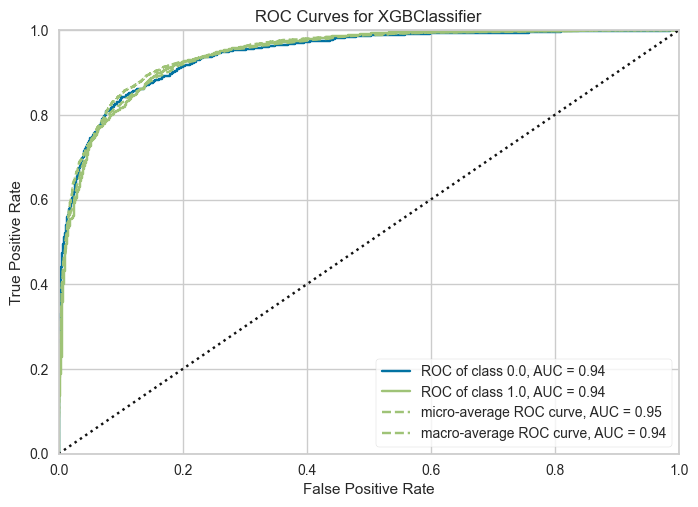

In [13]:
exp.plot_model(haim_model, plot='auc')

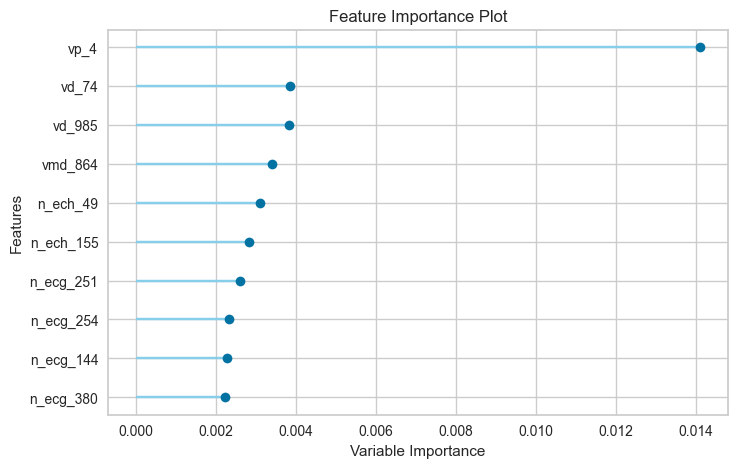

In [14]:
exp.plot_model(haim_model, plot='feature')

#### PyCaret best model

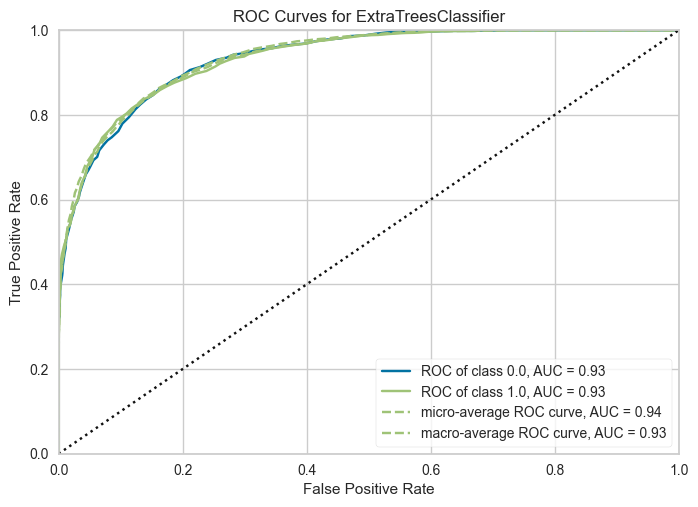

In [15]:
exp.plot_model(pycaret_model, plot='auc')

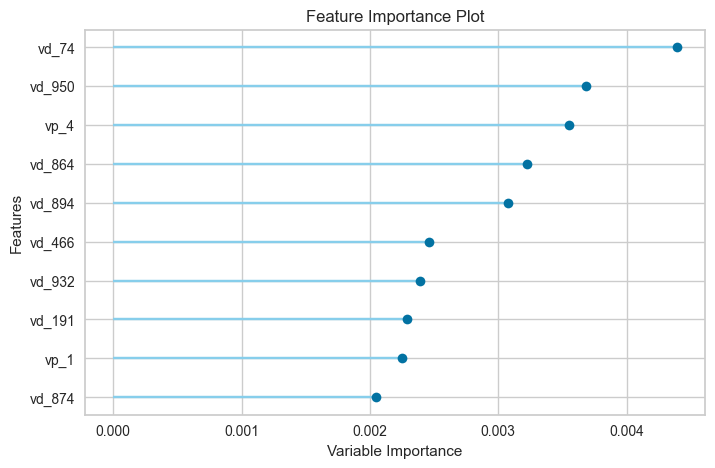

In [16]:
exp.plot_model(pycaret_model, plot='feature')

### Interpret model
#### HAIM model

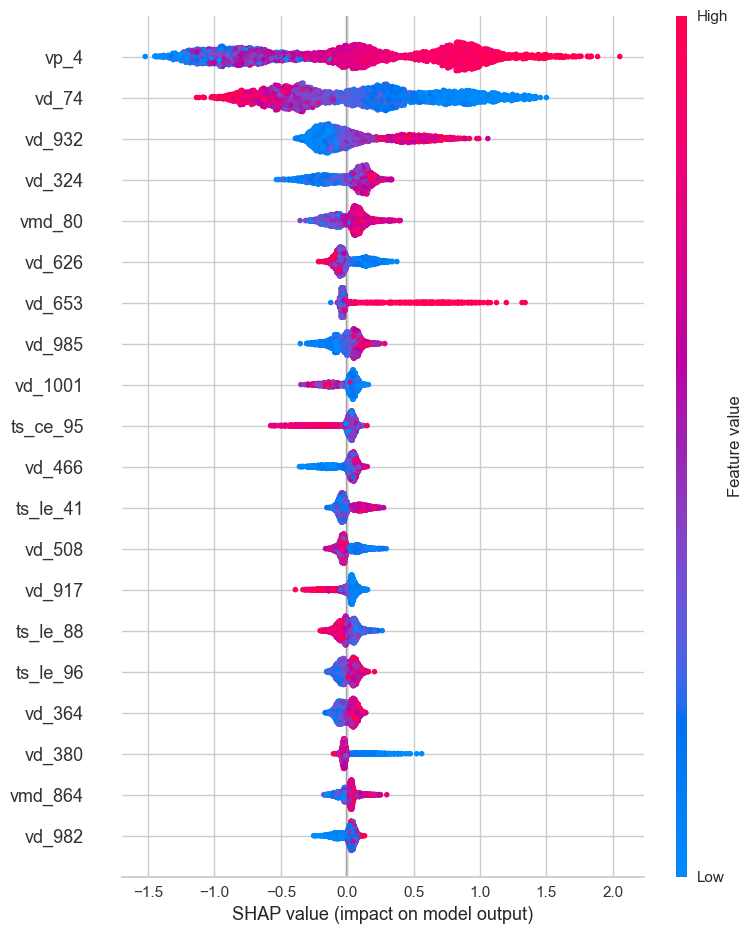

In [17]:
exp.interpret_model(haim_model, plot='summary')

#### PyCaret best model

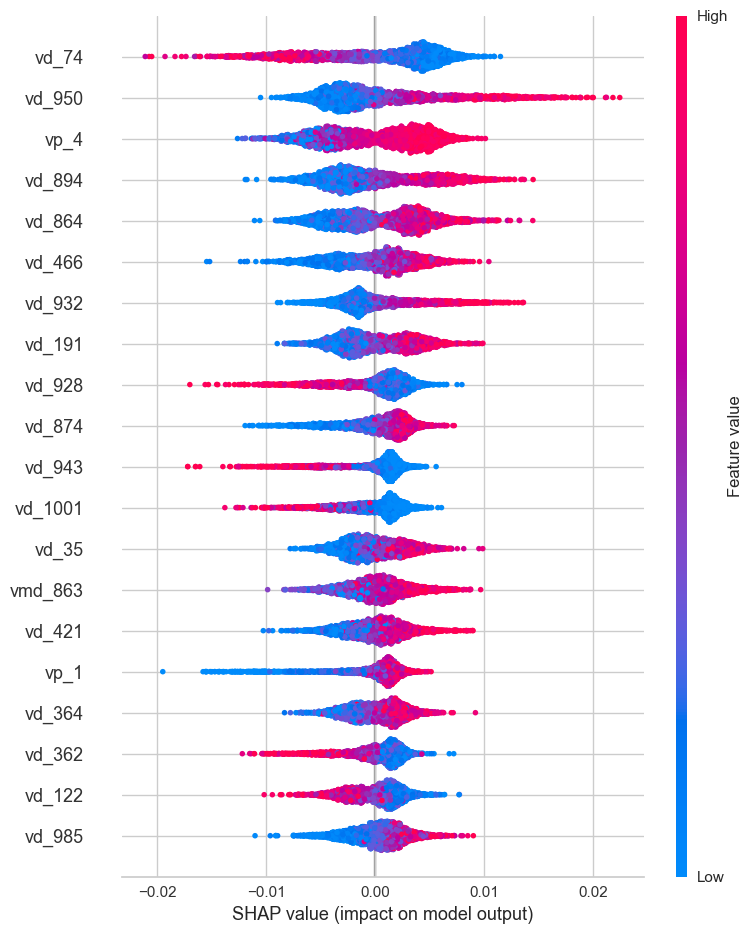

In [18]:
exp.interpret_model(pycaret_model, plot='summary')

### Save / Load models
#### HAIM model

In [19]:
exp.save_model(haim_model, 'best_models/edema_haim_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['haim_id', 'de_0', 'de_1', 'de_2',
                                              'de_3', 'de_4', 'de_5', 'vd_0',
                                              'vd_1', 'vd_2', 'vd_3', 'vd_4',
                                              'vd_5', 'vd_6', 'vd_7', 'vd_8',
                                              'vd_9', 'vd_10', 'vd_11', 'vd_12',
                                              'vd_13', 'vd_14', 'vd_15', 'vd_16',
                                              'vd_17', 'vd_18', 'vd_19', 'vd_20',
                                              'vd_21', 'vd_22', ...],
                                     t...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                                ma

In [20]:
load_haim_model = exp.load_model('best_models/edema_haim_model')

Transformation Pipeline and Model Successfully Loaded


#### PyCaret best model

In [21]:
exp.save_model(pycaret_model, 'best_models/edema_pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['haim_id', 'de_0', 'de_1', 'de_2',
                                              'de_3', 'de_4', 'de_5', 'vd_0',
                                              'vd_1', 'vd_2', 'vd_3', 'vd_4',
                                              'vd_5', 'vd_6', 'vd_7', 'vd_8',
                                              'vd_9', 'vd_10', 'vd_11', 'vd_12',
                                              'vd_13', 'vd_14', 'vd_15', 'vd_16',
                                              'vd_17', 'vd_18', 'vd_19', 'vd_20',
                                              'vd_21', 'vd_22', ...],
                                     t...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       m

In [22]:
load_pycaret_model = exp.load_model('best_models/edema_pycaret_model')

Transformation Pipeline and Model Successfully Loaded
